# Federated Learning on Emotion Recognition

In [1]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open(r'C:\Users\sreed\VSCODE_CoDING\Project_Phase_1\Flower_Federated\Dataset\train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


In [9]:
y_train[0]

0

In [3]:
y_train

array([0, 0, 2, ..., 4, 0, 4])

In [2]:
x_train

array([[[ 70,  80,  82, ...,  52,  43,  41],
        [ 65,  61,  58, ...,  56,  52,  44],
        [ 50,  43,  54, ...,  49,  56,  47],
        ...,
        [ 91,  65,  42, ...,  72,  56,  43],
        [ 77,  82,  79, ..., 105,  70,  46],
        [ 77,  72,  84, ..., 106, 109,  82]],

       [[151, 150, 147, ..., 129, 140, 120],
        [151, 149, 149, ..., 122, 141, 137],
        [151, 151, 156, ..., 109, 123, 146],
        ...,
        [188, 188, 121, ..., 185, 185, 186],
        [188, 187, 196, ..., 186, 182, 187],
        [186, 184, 185, ..., 193, 183, 184]],

       [[231, 212, 156, ...,  44,  27,  16],
        [229, 175, 148, ...,  27,  35,  27],
        [214, 156, 157, ...,  28,  22,  28],
        ...,
        [241, 245, 250, ...,  57, 101, 146],
        [246, 250, 252, ...,  78, 105, 162],
        [250, 251, 250, ...,  88, 110, 152]],

       ...,

       [[ 74,  81,  87, ..., 189, 191, 192],
        [ 78,  82,  89, ..., 185, 189, 193],
        [ 81,  86,  94, ..., 176, 185, 193

Label is: 0


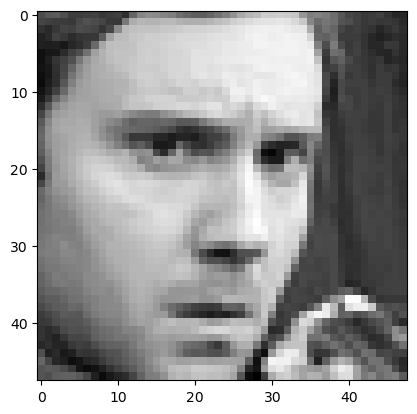

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# Show some image
image = x_train[0]
label = y_train[0]

print('Label is: ' + str(label))
plt.imshow(image, cmap='gray')

### Preprocess Data

In [3]:
# %tensorflow_version
import tensorflow as tf

print('Tensorflow version: {}'.format(tf.__version__))

from tensorflow import reshape
from collections import OrderedDict


TRAIN_DATA_PER_CLIENT = 300

TRAINING_EPOCHS = 1

x_client_1 = x_train[0 : TRAIN_DATA_PER_CLIENT]
y_client_1 = y_train[0 : TRAIN_DATA_PER_CLIENT]

x_client_2 = x_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]
y_client_2 = y_train[TRAIN_DATA_PER_CLIENT : TRAIN_DATA_PER_CLIENT * 2]

x_client_3 = x_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
y_client_3 = y_train[TRAIN_DATA_PER_CLIENT * 2 : TRAIN_DATA_PER_CLIENT * 3]
print(x_client_3.shape)

x_test = x_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]
y_test = y_train[TRAIN_DATA_PER_CLIENT * 3 : TRAIN_DATA_PER_CLIENT * 4]

def create_federated_data(x_train, y_train):

    orderDict = OrderedDict()
    pixels_list = []
    
    x_train = x_train / 255.0
    x_train = x_train.reshape(len(x_train), 48, 48, 1)

    orderDict['x'] = numpy.array(x_train)
    orderDict['y'] = numpy.array(y_train)
    dataset = tf.data.Dataset.from_tensor_slices(orderDict)
    batch = dataset.shuffle(10).batch(5)

    return batch

federated_data_client_1 = [create_federated_data(x_client_1, y_client_1) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_2 = [create_federated_data(x_client_2, y_client_2) for epoch in range(TRAINING_EPOCHS)]
federated_data_client_3 = [create_federated_data(x_client_3, y_client_3) for epoch in range(TRAINING_EPOCHS)]

federated_data_test = [create_federated_data(x_test, y_test) for epoch in range(TRAINING_EPOCHS)]

print('Total training epochs: {}'.format(len(federated_data_client_3)))

Tensorflow version: 2.3.4
(300, 48, 48)
Total training epochs: 30


In [4]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

def create_keras_model():

    vgg = VGG19(input_shape=(48,48,1), weights=None, include_top=False)
#     vgg = vgg16.VGG16(include_top=False, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 1)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(7, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=prediction)
    return model
x_train = x_train.reshape(len(x_train), 48, 48, 1)
# Summary model
input_shape=x_train[0].shape
keras_model = create_keras_model()
keras_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

In [5]:
import tensorflow_federated as tff

# Create dummy batch
dummy_batch = tf.nest.map_structure(lambda x: x.numpy(), iter(federated_data_client_1[0]).next())
print(dummy_batch['x'].shape)

def create_federated_model():

    keras_model = create_keras_model()
    
    return tff.learning.from_keras_model(keras_model,SparseCategoricalCrossentropy(),input_spec=federated_data_client_1[0].element_spec,metrics=[SparseCategoricalAccuracy()])

(5, 48, 48, 1)


In [6]:
import nest_asyncio
nest_asyncio.apply()

In [7]:
trainer = tff.learning.build_federated_averaging_process(create_federated_model, client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02))

train_state = trainer.initialize()

In [8]:
print('========== Train on Local Device of Client 1 ==========')

history_accuracy_1 = []
history_loss_1 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_1)
    history_accuracy_1.append(train_metrics['train']['sparse_categorical_accuracy'])
    history_loss_1.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

plt.title('Model Accuracy for Client 1')
plt.plot(history_accuracy_1, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 1')
plt.plot(history_loss_1, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 1 ==========
round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.20955555), ('loss', 1.9306704)]))])


KeyboardInterrupt: 

In [ ]:
print('========== Train on Local Device of Client 2 ==========')

history_accuracy_2 = []
history_loss_2 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_2)
    history_accuracy_2.append(train_metrics['train']['sparse_categorical_accuracy'])
    history_loss_2.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

plt.title('Model Accuracy for Client 2')
plt.plot(history_accuracy_2, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 2')
plt.plot(history_loss_2, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

========== Train on Local Device of Client 2 ==========
round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.18966667), ('loss', 1.8718635)]))])


In [ ]:
print('========== Train on Local Device of Client 3 ==========')

history_accuracy_3 = []
history_loss_3 = []

for round_num in range(6):
    train_state, train_metrics = trainer.next(train_state, federated_data_client_3)
    history_accuracy_3.append(train_metrics['train']['sparse_categorical_accuracy'])
    history_loss_3.append(train_metrics['train']['loss'])
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))

plt.title('Model Accuracy for Client 3')
plt.plot(history_accuracy_3, label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Model Loss for Client 3')
plt.plot(history_loss_3, label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
evaluator = tff.learning.build_federated_evaluation(create_federated_model)

In [14]:
test_metrics = evaluator(train_state.model, federated_data_test)
print(test_metrics)

OrderedDict([('sparse_categorical_accuracy', 0.25), ('loss', 1.8381093)])
